In [2]:
# Basic packages for data handling
import pandas as pd   # For data frames and reading the CSV file
import numpy as np    # For numerical operations

# Visualization (we will use it during data exploration and evaluation)
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
from xgboost import XGBClassifier

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
# Load the dataset
df = pd.read_csv('Fraud_Subset_50_50_10k_each.csv')

# Display basic info
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fraud                      20000 non-null  int64  
 1   trustLevel                 20000 non-null  int64  
 2   totalScanTimeInSeconds     20000 non-null  int64  
 3   lineItemVoids              20000 non-null  int64  
 4   quantityModification       20000 non-null  int64  
 5   grandTotal                 20000 non-null  float64
 6   scannedLineItemsPerSecond  20000 non-null  float64
 7   valuePerSecond             20000 non-null  float64
 8   lineItemVoidsPerPosition   20000 non-null  float64
 9   scansWithoutRegistration   20000 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.5 MB


,fraud,trustLevel,totalScanTimeInSeconds,lineItemVoids,quantityModification,grandTotal,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scansWithoutRegistration
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.500000,2.423400,1029.035550,6.002000,2.499200,50.363867,0.055049,0.149222,0.499350,5.547350
std,0.500013,1.705954,518.224282,3.422496,1.711592,28.490840,0.431907,1.165267,0.970803,3.135961
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000547,0.000000,0.000000,0.000000
25%,0.000000,1.000000,591.000000,3.000000,1.000000,26.157500,0.013861,0.025379,0.153846,3.000000
50%,0.500000,2.000000,1085.000000,6.000000,2.000000,50.400000,0.019568,0.048841,0.300000,6.000000
75%,1.000000,4.000000,1486.000000,9.000000,4.000000,74.900000,0.034279,0.086795,0.434783,8.000000
max,1.000000,6.000000,1831.000000,11.000000,5.000000,99.990000,30.000000,70.840000,11.000000,10.000000


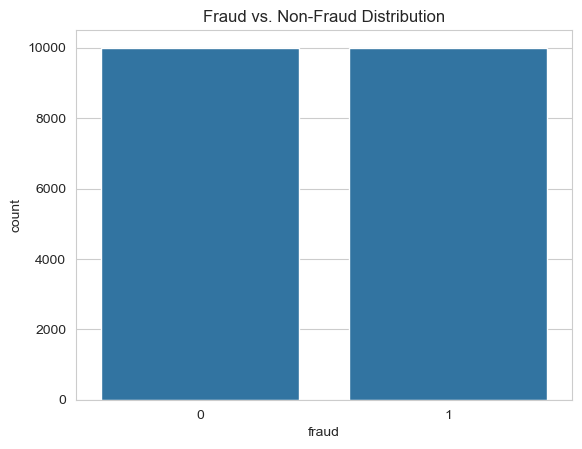

In [4]:
# Count of each class
sns.countplot(x='fraud', data=df)
plt.title('Fraud vs. Non-Fraud Distribution')
plt.show()


In [5]:
# Check for missing values
df.isnull().sum()

fraud                        0
trustLevel                   0
totalScanTimeInSeconds       0
lineItemVoids                0
quantityModification         0
grandTotal                   0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
scansWithoutRegistration     0
dtype: int64

In [6]:
# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


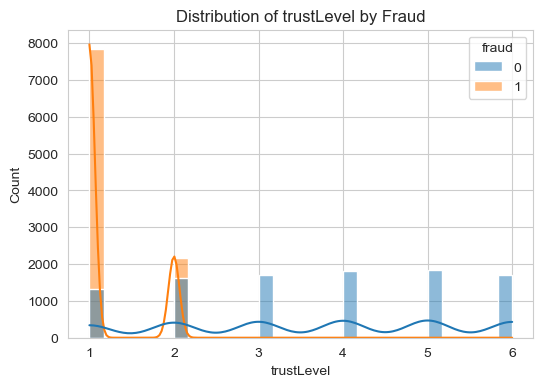

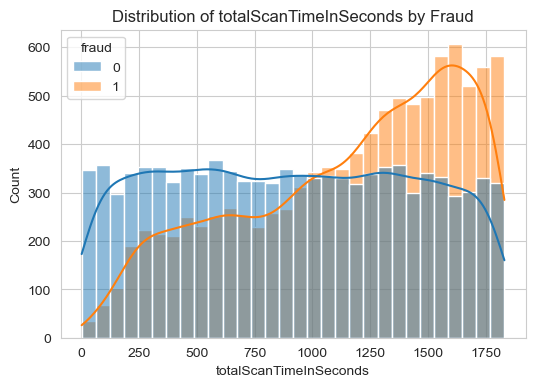

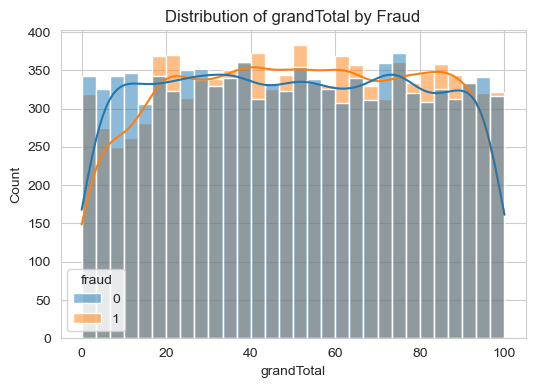

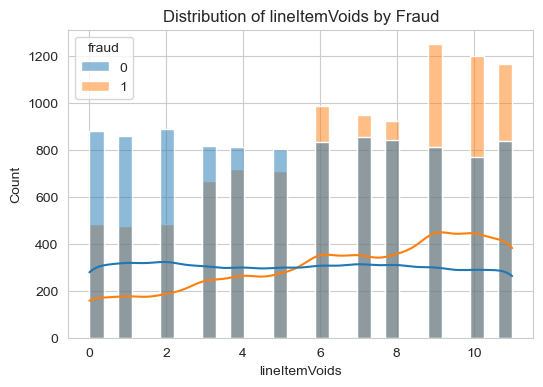

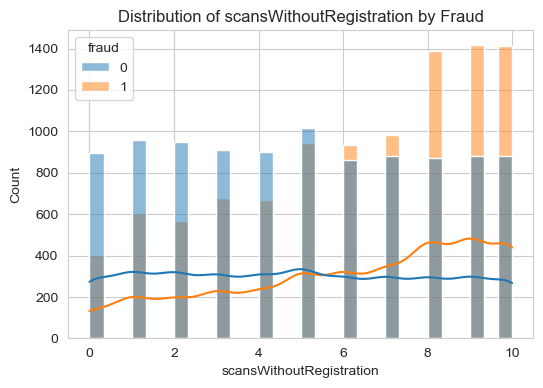

In [7]:
# List of features you want to check
features_to_plot = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration']

# Plot distributions
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='fraud', kde=True, bins=30)
    plt.title(f'Distribution of {feature} by Fraud')
    plt.show()


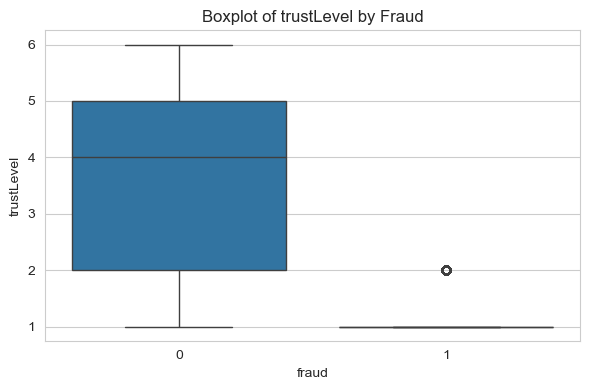

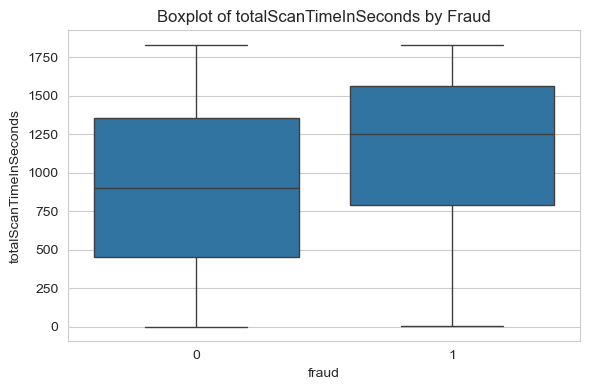

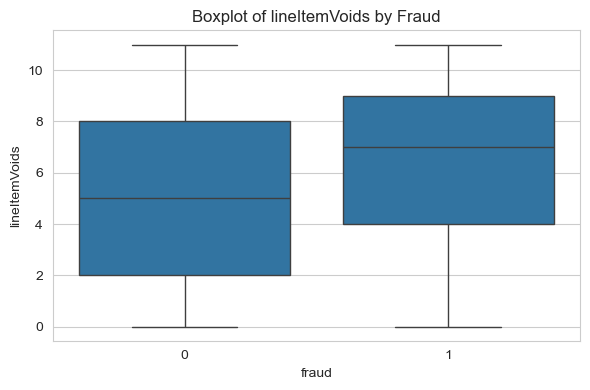

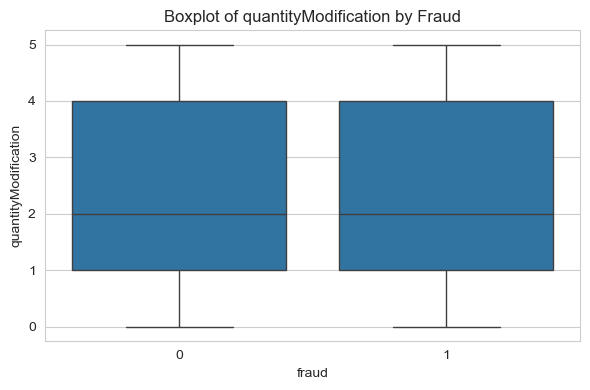

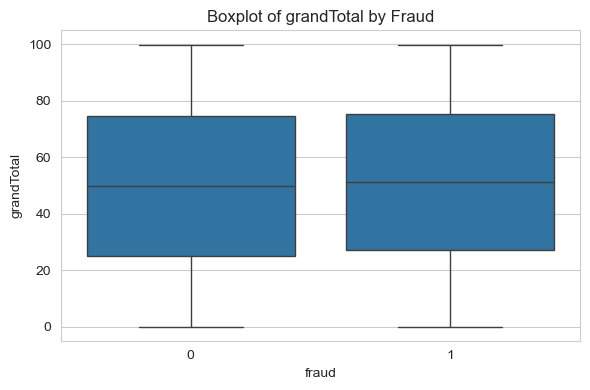

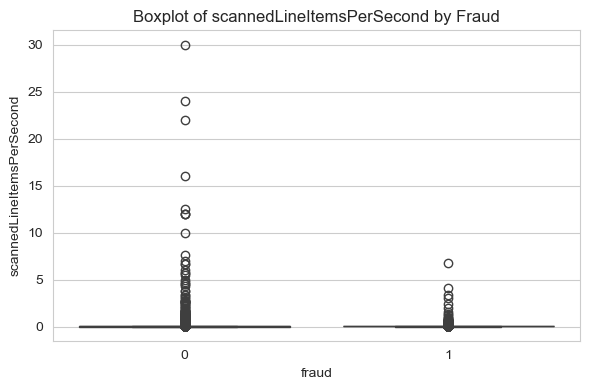

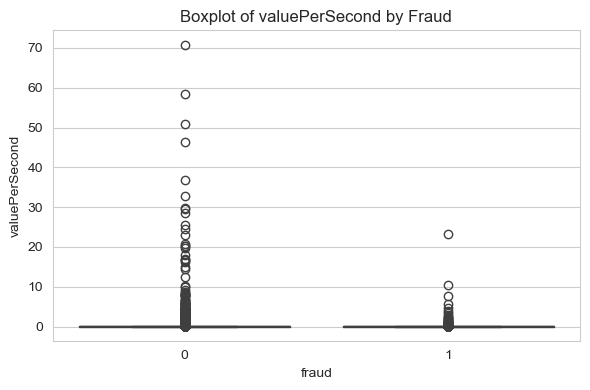

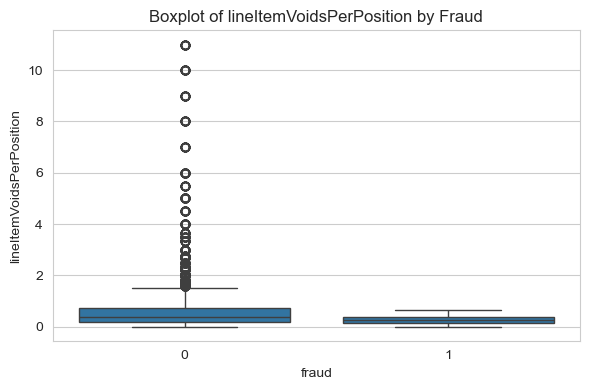

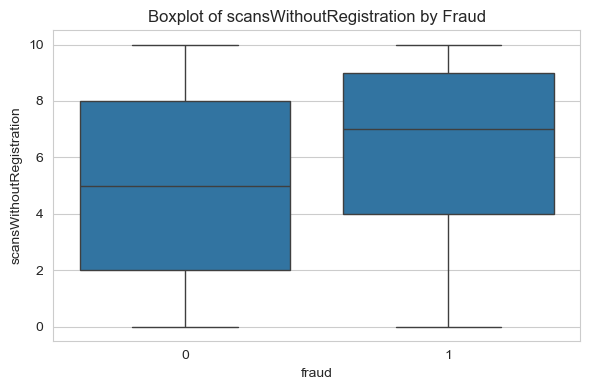

In [8]:
# Automatically detect numeric features (excluding the target column)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('fraud')  # Exclude the target variable

# Boxplots for all numeric features
for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='fraud', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Fraud')
    plt.tight_layout()
    plt.show()


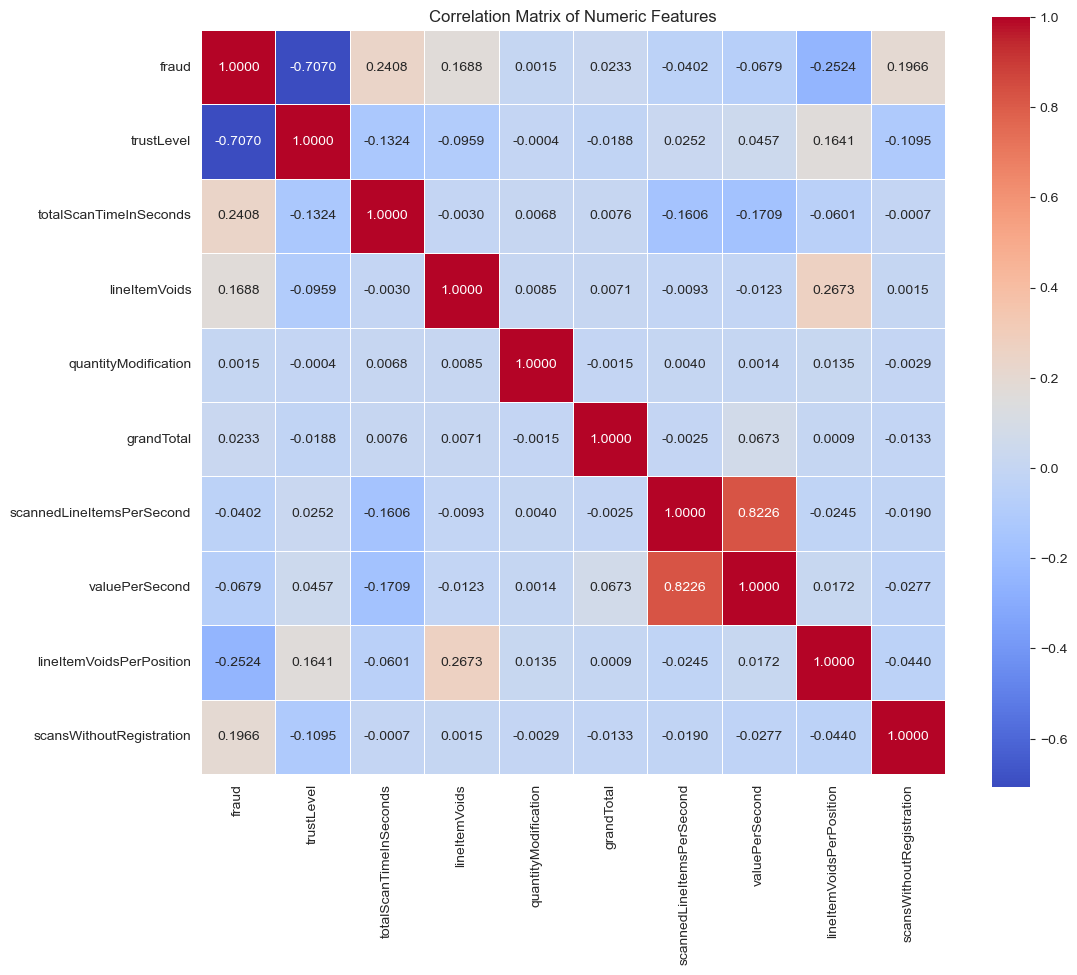

In [9]:
# Compute correlation matrix (only numeric features)
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


In [10]:
# Check for missing values
df.isnull().sum()

fraud                        0
trustLevel                   0
totalScanTimeInSeconds       0
lineItemVoids                0
quantityModification         0
grandTotal                   0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
scansWithoutRegistration     0
dtype: int64

In [11]:
# Separate target and features
X = df.drop('fraud', axis=1)
y = df['fraud']

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Create the model
model = XGBClassifier(eval_metric='logloss', random_state=42)

# Evaluate using cross-validation (f1-score as an example)
scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(f1_score))

print("F1 scores for each fold:", scores)
print("Average F1 score:", scores.mean())

F1 scores for each fold: [0.98716683 0.98836922 0.9893538  0.98933796 0.99058007]
Average F1 score: 0.9889615756811752


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(50, 300),              # number of trees
    'max_depth': randint(3, 10),                   # max tree depth
    'learning_rate': uniform(0.01, 0.3),           # step size shrinkage
    'subsample': uniform(0.6, 0.4),                # % of samples per tree
    'colsample_bytree': uniform(0.6, 0.4),         # % of features per tree
    'gamma': uniform(0, 5),                        # minimum loss reduction
    'reg_alpha': uniform(0, 1),                    # L1 regularization
    'reg_lambda': uniform(0, 1)                    # L2 regularization
}

from sklearn.metrics import make_scorer, f1_score

model = XGBClassifier(eval_metric='logloss', random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of random combinations to try
    scoring=make_scorer(f1_score),
    cv=5,       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all CPU cores
)

random_search.fit(X, y)

print("Best F1 Score:", random_search.best_score_)
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best F1 Score: 0.9887672745523985
Best Parameters: {'colsample_bytree': 0.7297380084021096, 'gamma': 0.6104397735033668, 'learning_rate': 0.11688935142309247, 'max_depth': 8, 'n_estimators': 274, 'reg_alpha': 0.2721322493846353, 'reg_lambda': 0.6476901205413623, 'subsample': 0.6002081507981263}


In [15]:
# Train final model using best parameters
best_model = XGBClassifier(
    colsample_bytree=0.7297,
    gamma=0.6104,
    learning_rate=0.1169,
    max_depth=8,
    n_estimators=274,
    reg_alpha=0.2721,
    reg_lambda=0.6477,
    subsample=0.6002,
    eval_metric='logloss',
    random_state=42
)

best_model.fit(X, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7297, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.6104,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1169, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=274, n_jobs=None,
              num_parallel_tree=None, ...)

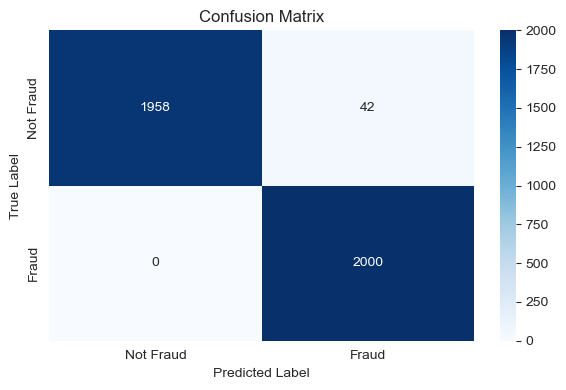

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2000
           1       0.98      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Train the final model on the training set
best_model.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred = best_model.predict(X_test)

# Step 4: Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 5: Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 6: Print precision, recall, f1-score
print(classification_report(y_test, y_pred, digits=2))


C:\Users\schne\AppData\Local\Temp\ipykernel_14060\264483003.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


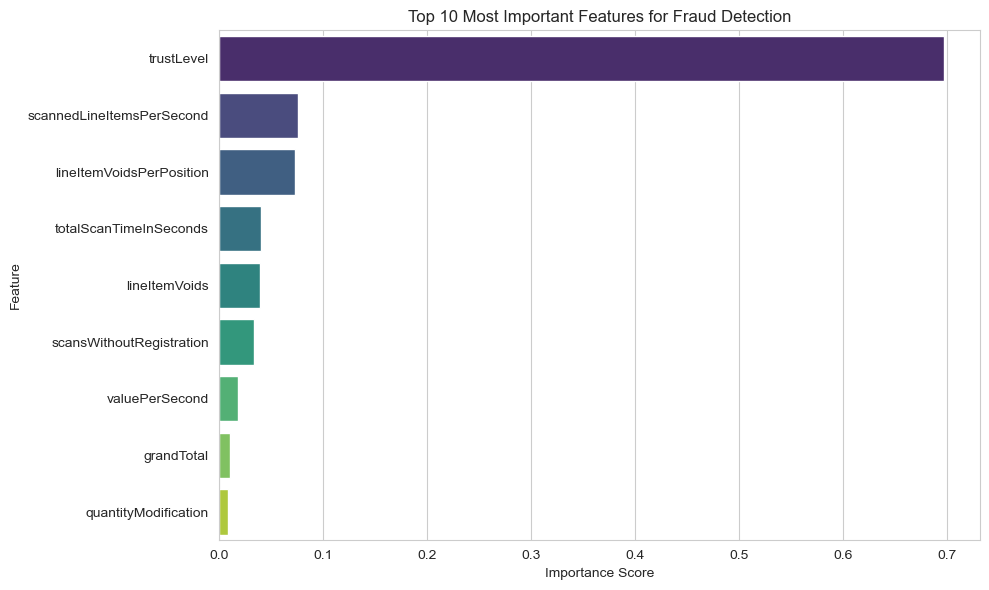

In [18]:
# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances and feature names
importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top N features
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Most Important Features for Fraud Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [19]:
import joblib

# Save the trained model to a file
joblib.dump(best_model, 'xgboost_fraud_model.pkl')


['xgboost_fraud_model.pkl']

C:\Users\schne\anaconda3\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tpng']' returned non-zero exit status 3221225477. [stderr: b'']

<Figure size 3000x1000 with 0 Axes>

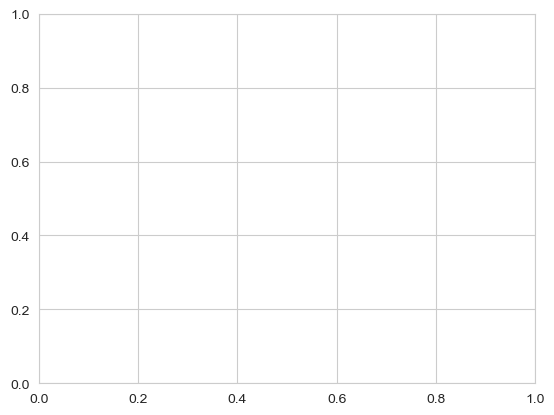

In [39]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
# Plot the first tree (tree 0)
plt.figure(figsize=(30, 10))
plot_tree(best_model, num_trees=0, rankdir='LR')
plt.title("XGBoost - Tree 0")
plt.show()
